# Support for XGBoost, LightGBM, CatBoost — Issue #92

This notebook demonstrates using `calibrated-explanations` with popular scikit-learn compatible libraries:
- XGBoost (`xgboost.XGBClassifier`)
- LightGBM (`lightgbm.LGBMClassifier`)
- CatBoost (`catboost.CatBoostClassifier`)

The `CalibratedExplainer` is model-agnostic: it only requires a fitted learner exposing `predict_proba` (classification) or `predict` (regression).

Each section below is a small, self-contained example using a tiny synthetic dataset. If a library is not installed, its section will gracefully skip with a message.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib
import os
import subprocess
import sys

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

RUN_INSTALL = False  # set to True to install via pip from this notebook

if RUN_INSTALL:
    subprocess.check_call(  # noqa: S603 - constant command for optional local installs
        [
            sys.executable,
            "-m",
            "pip",
            "install",
            "-q",
            "xgboost",
            "lightgbm",
            "catboost",
            "scikit-learn",
        ],
    )

repo_src = os.path.abspath(os.path.join("..", "src"))
if repo_src not in sys.path:
    sys.path.insert(0, repo_src)

# Force reload of modules to pick up recent changes
if "calibrated_explanations.explanations.explanation" in sys.modules:
    del sys.modules["calibrated_explanations.explanations.explanation"]
if "calibrated_explanations.core.calibrated_explainer" in sys.modules:
    del sys.modules["calibrated_explanations.core.calibrated_explainer"]

CalibratedExplainer = importlib.import_module(
    "calibrated_explanations.core.calibrated_explainer"
).CalibratedExplainer
from calibrated_explanations import __version__


def make_tiny_binary(n_samples=200, n_features=8, random_state=42):
    features, labels = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=max(2, n_features // 3),
        n_redundant=0,
        n_repeated=0,
        n_classes=2,
        random_state=random_state,
    )
    tmp_features, test_features, tmp_labels, test_labels = train_test_split(
        features, labels, test_size=0.2, random_state=random_state
    )
    train_features, calibration_features, train_labels, calibration_labels = train_test_split(
        tmp_features, tmp_labels, test_size=0.25, random_state=random_state
    )  # 0.25 * 0.8 = 0.2
    return (
        train_features,
        train_labels,
        calibration_features,
        calibration_labels,
        test_features,
        test_labels,
    )


from calibrated_explanations import __version__

print(f"Using calibrated_explanations version: {__version__}")

Using calibrated_explanations version: v0.10.2


## XGBoost (XGBClassifier)

XGBoost proba_uncal shape: (40, 2)
XGBoost proba_cal shape: (40, 2)
XGBoost first 3 calibrated probs: [0.08333333 0.29411765 0.83333333]
XGBoost first 3 intervals: [(0.0, 0.09090909090909091), (0.2, 0.3333333333333333), (0.8260869565217391, 0.8695652173913043)]
XGBoost first 10 calibrated predictions: ['0' '0' '1' '0' '1' '0' '1' '0' '1' '1']


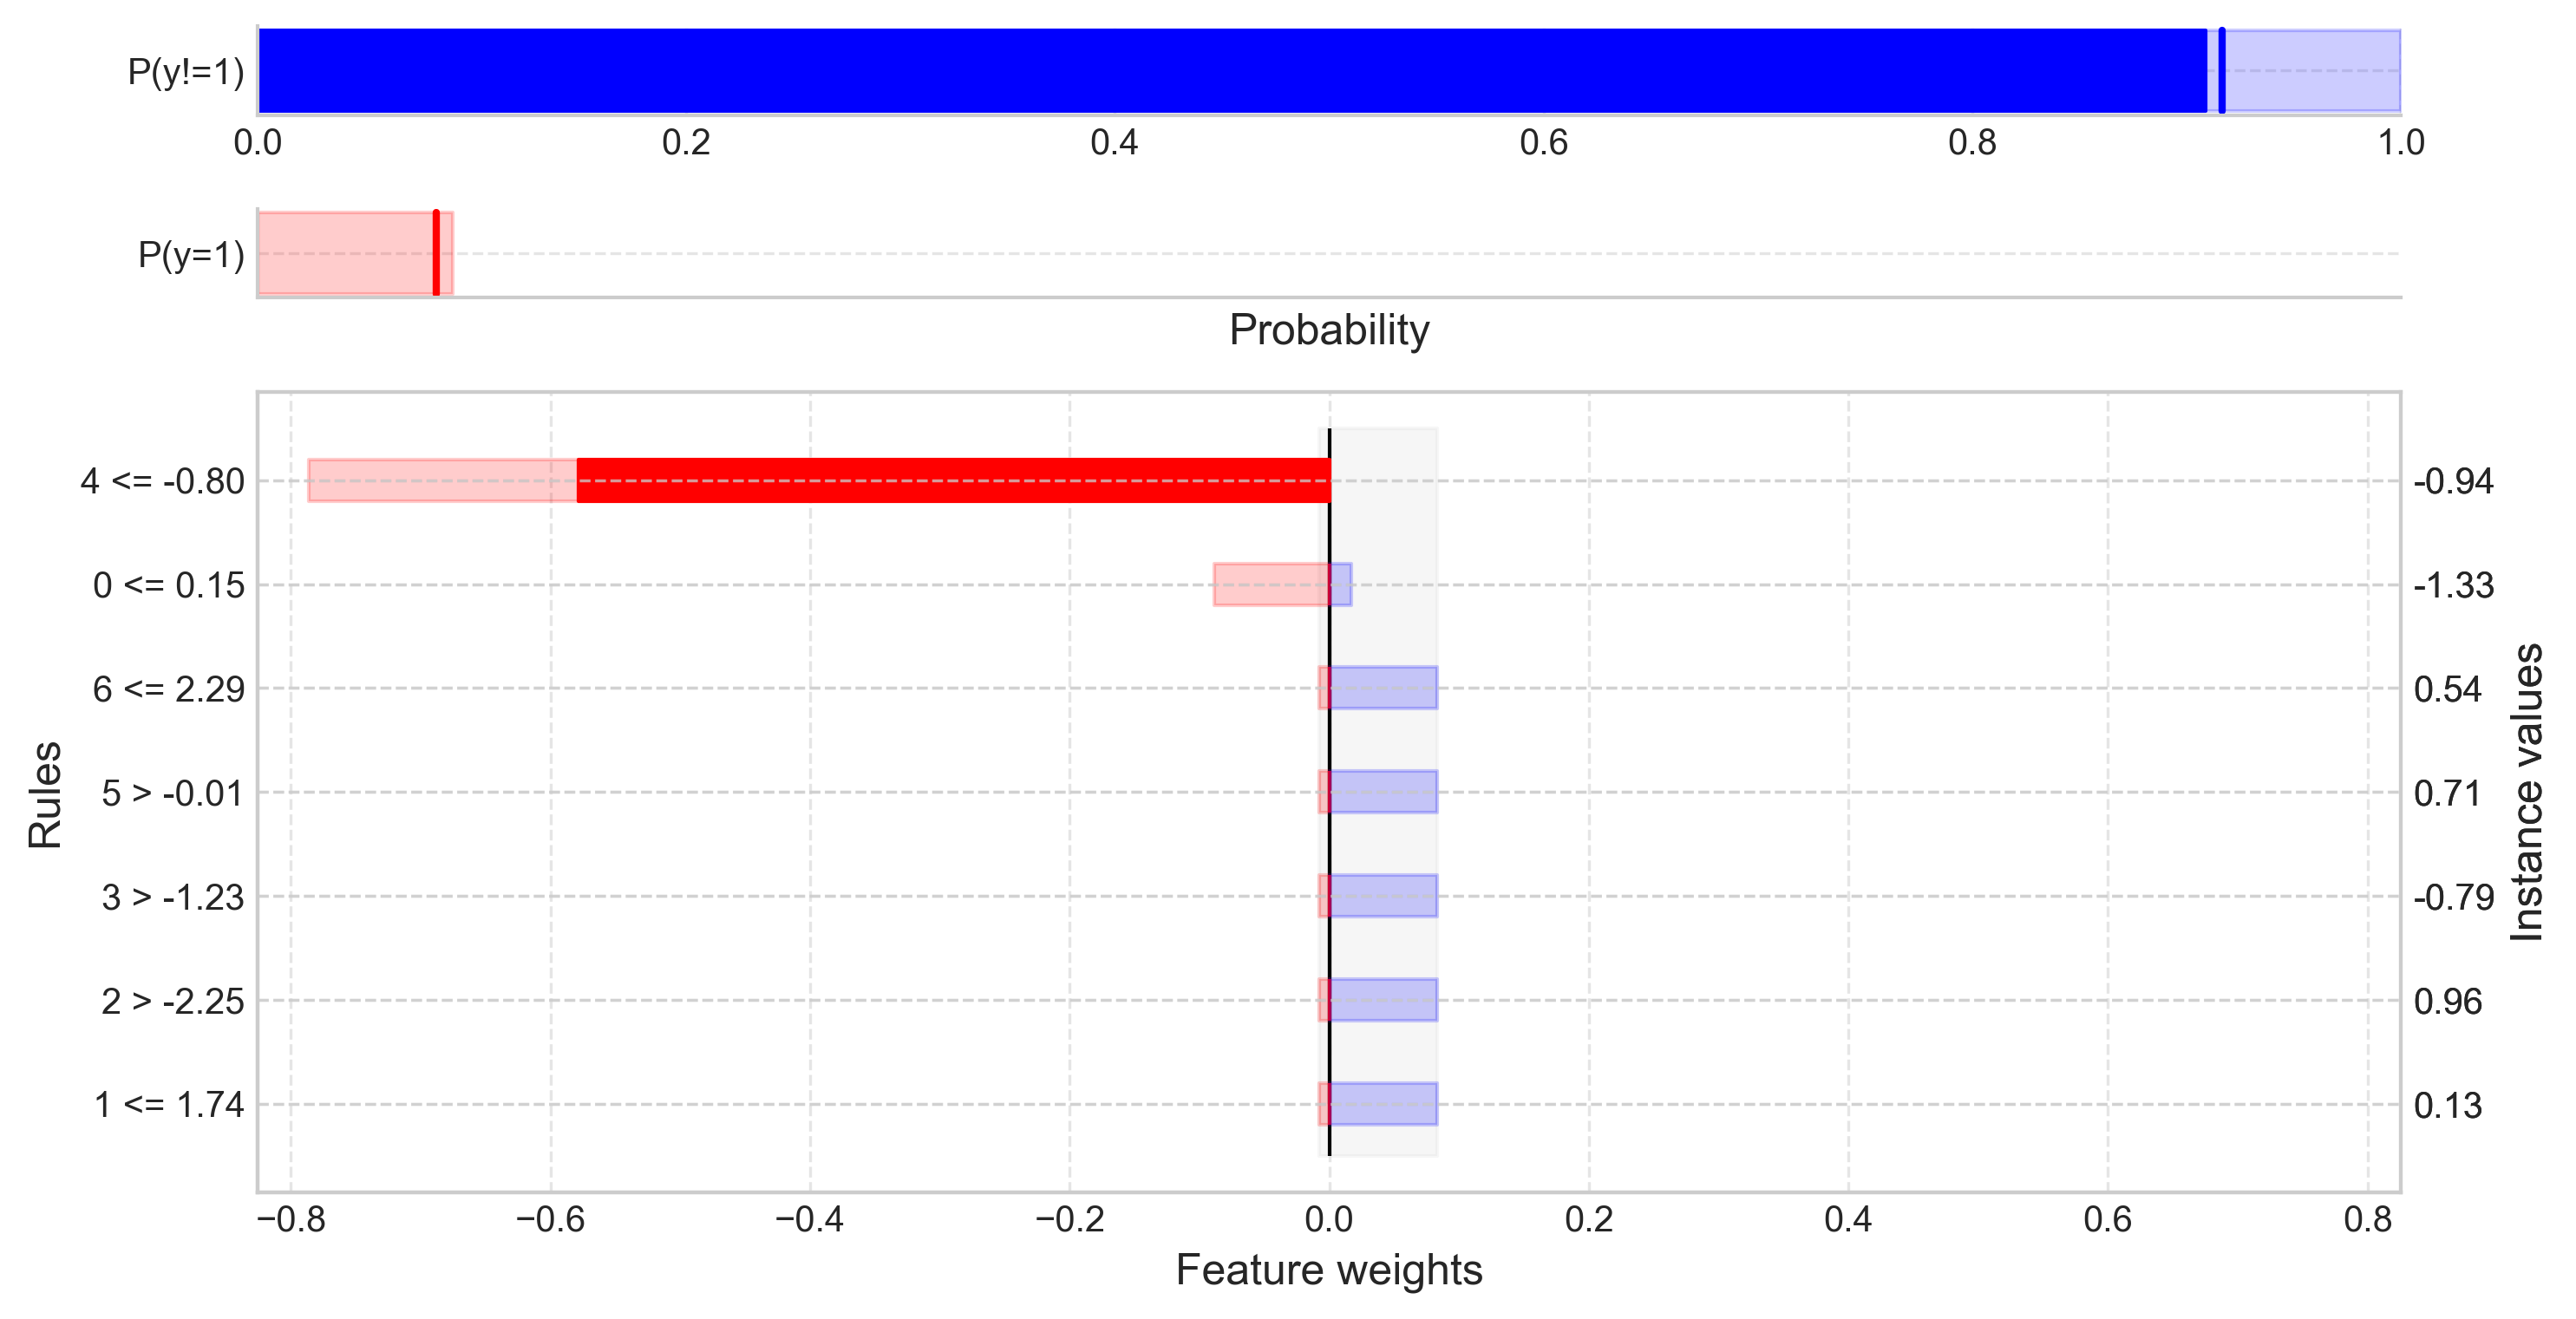

In [3]:
try:
    import xgboost as xgb
except Exception as e:
    print("xgboost not available, skipping XGBoost demo:", e)
else:
    (
        train_features,
        train_labels,
        calibration_features,
        calibration_labels,
        test_features,
        test_labels,
    ) = make_tiny_binary()
    clf = xgb.XGBClassifier(
        n_estimators=25,
        max_depth=2,
        subsample=0.9,
        colsample_bytree=0.9,
        learning_rate=0.2,
        tree_method="hist",
        verbosity=0,
        random_state=42,
    )
    clf.fit(train_features, train_labels)

    ce = CalibratedExplainer(clf, calibration_features, calibration_labels, mode="classification")

    # Uncalibrated vs calibrated probabilities
    proba_uncal = ce.predict_proba(test_features, calibrated=False)
    proba_cal, (low, high) = ce.predict_proba(test_features, uq_interval=True)
    print("XGBoost proba_uncal shape:", proba_uncal.shape)
    print("XGBoost proba_cal shape:", proba_cal.shape)
    print("XGBoost first 3 calibrated probs:", proba_cal[:3, 1])
    print("XGBoost first 3 intervals:", list(zip(low[:3], high[:3])))

    y_hat, (y_low, y_high) = ce.predict(test_features, uq_interval=True)
    print("XGBoost first 10 calibrated predictions:", y_hat[:10])

    factuals = ce.explain_factual(x=test_features[:3])
    factuals[0].plot(uncertainty=True)

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\calibrated_explanations\viz\matplotlib_adapter.py:1199: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout(rect=(0, 0, 1, 0.94))


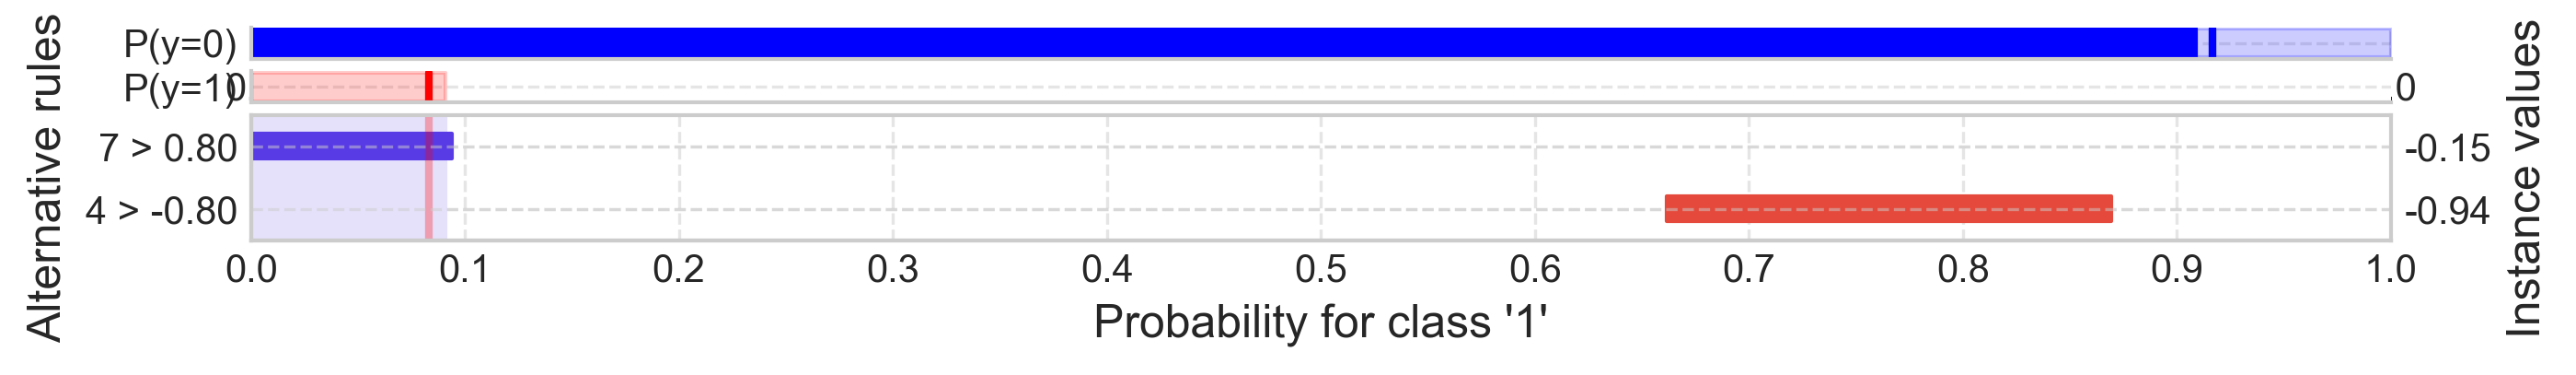

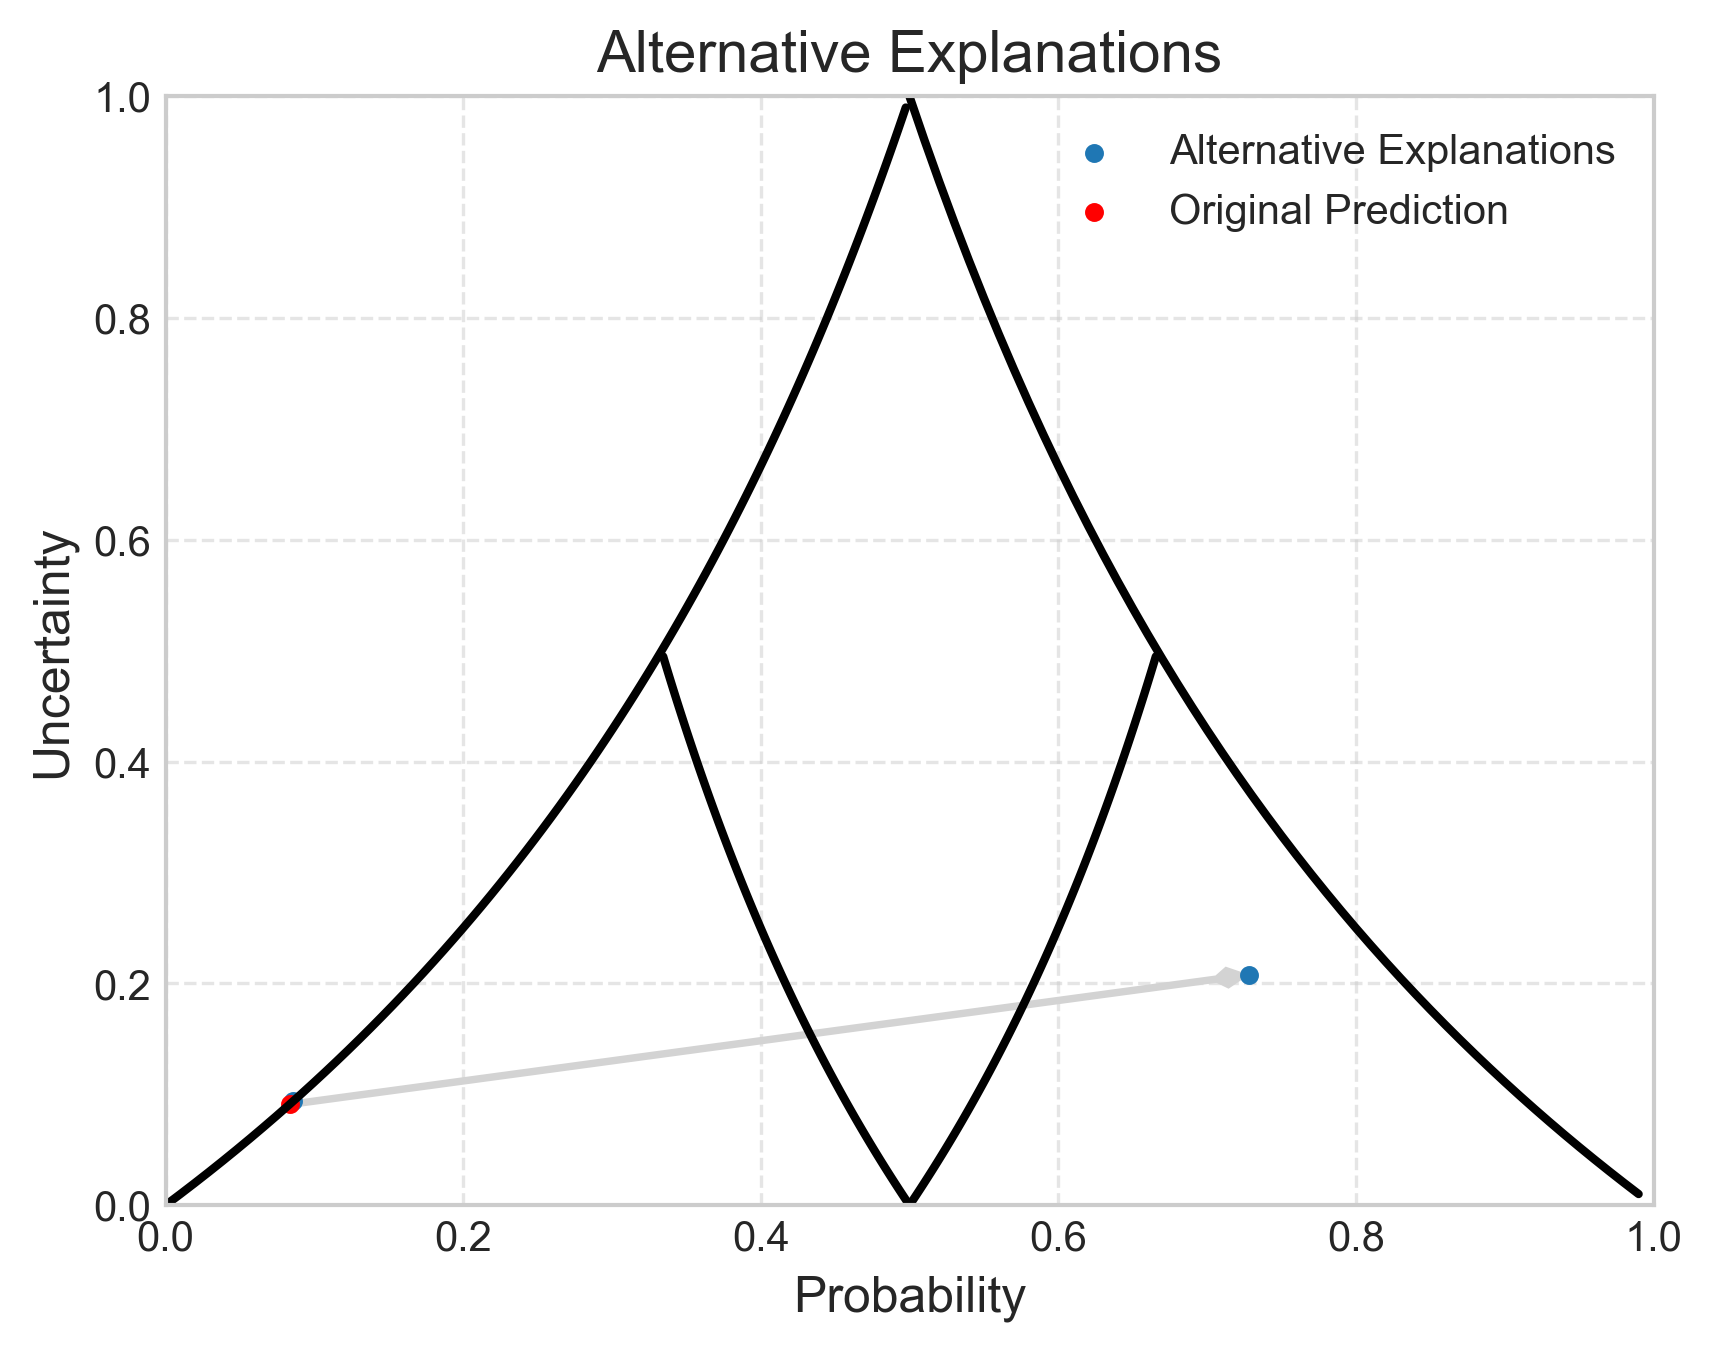

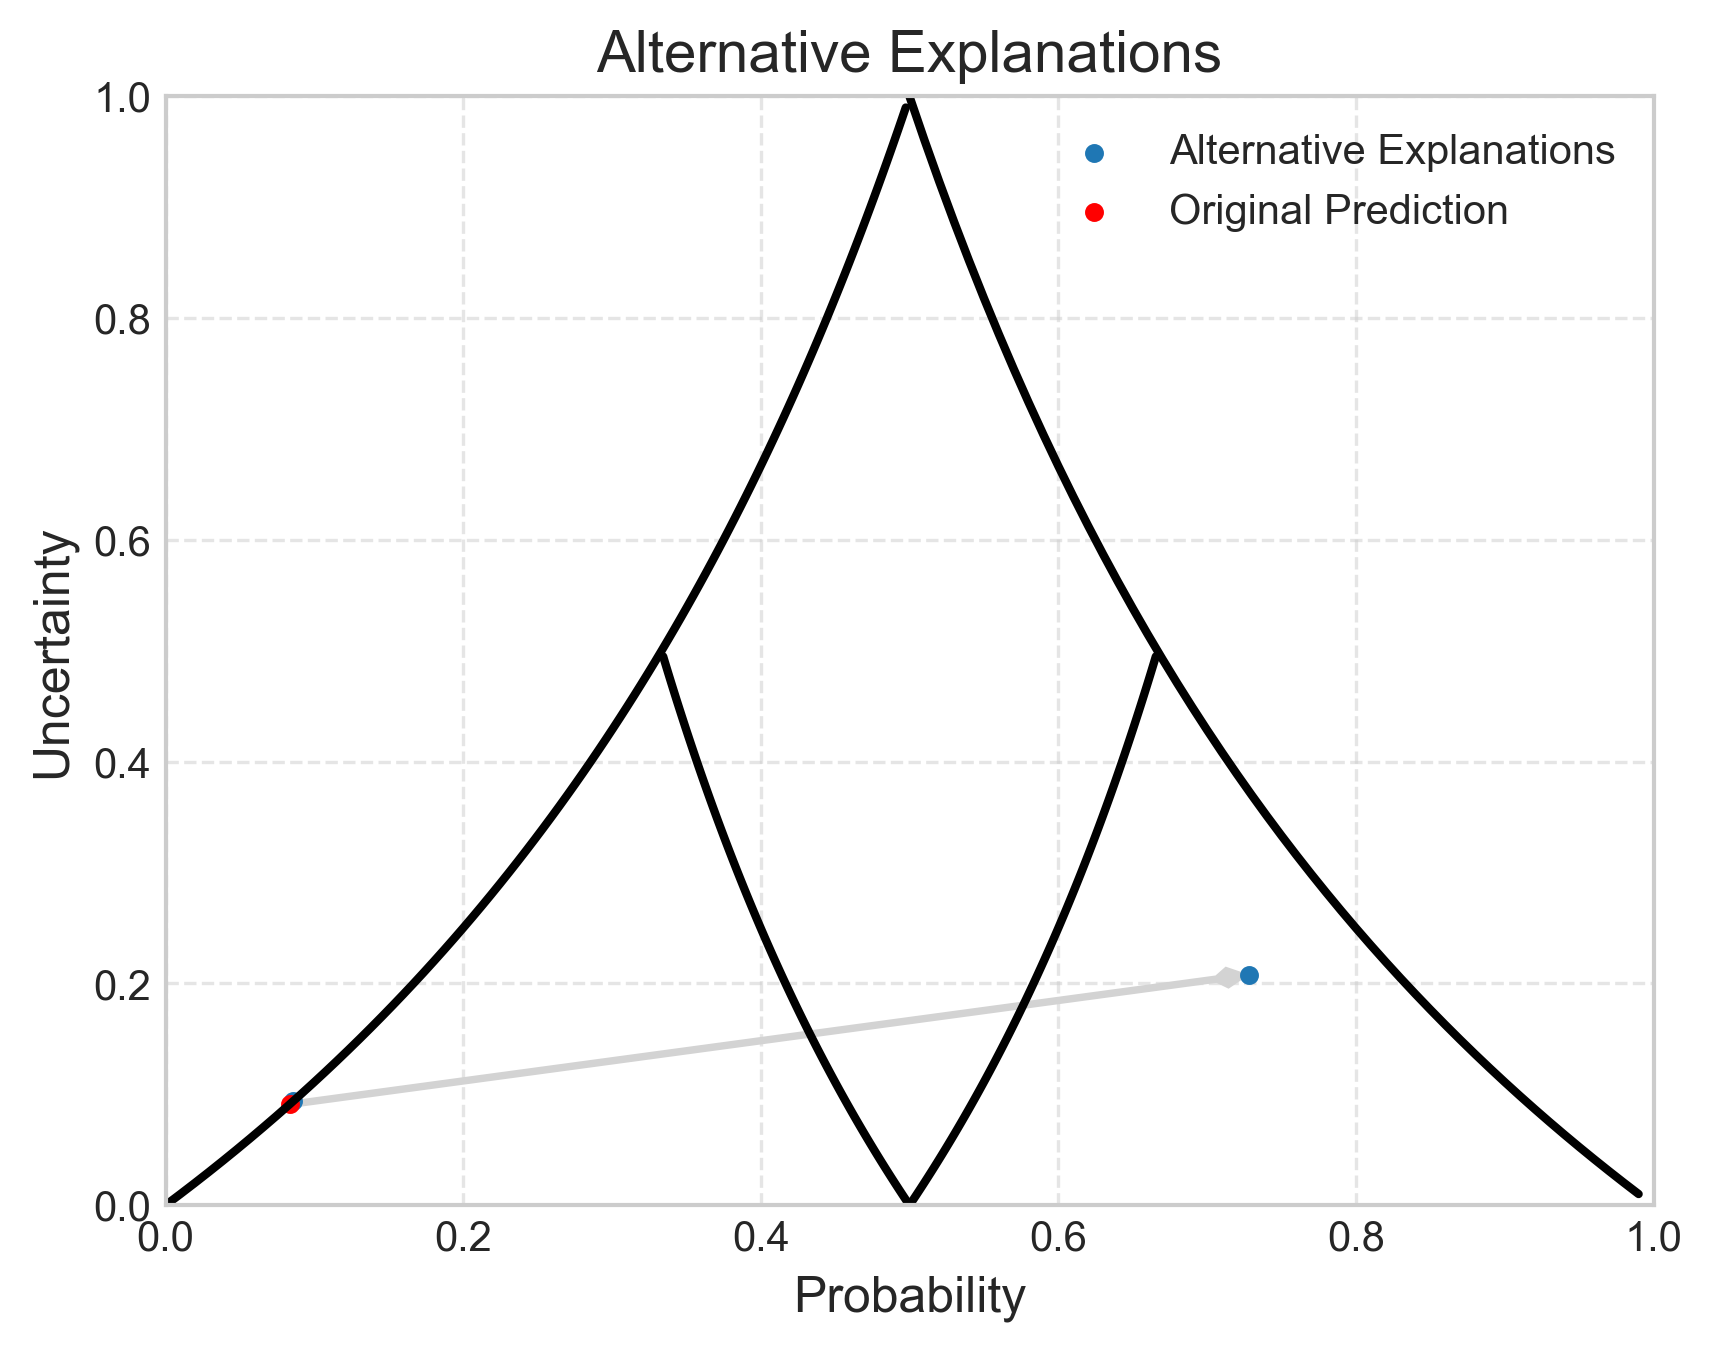

In [4]:
alternatives = ce.explore_alternatives(x=test_features[:3])
alternatives[0].plot(filter_top=3, rnk_metric="feature_weight")
alternatives[0].plot(style="triangular")
alternatives[0].add_conjunctions()
alternatives[0].plot(style="triangular")
# alternatives[0].plot(filter_top=3) # rnk_metric="ensured", rnk_weight=0.5
# alternatives[0].plot(filter_top=3, rnk_metric="ensured", rnk_weight=-0.5)
# alternatives[0].plot(filter_top=3, rnk_metric="uncertainty")

## LightGBM (LGBMClassifier)

In [ ]:
try:
    import lightgbm as lgb
except Exception as e:
    print("lightgbm not available, skipping LightGBM demo:", e)
else:
    (
        train_features,
        train_labels,
        calibration_features,
        calibration_labels,
        test_features,
        test_labels,
    ) = make_tiny_binary()
    clf = lgb.LGBMClassifier(
        n_estimators=50, learning_rate=0.2, subsample=0.9, colsample_bytree=0.9, random_state=42
    )
    clf.fit(train_features, train_labels)

    ce = CalibratedExplainer(clf, calibration_features, calibration_labels, mode="classification")
    proba_uncal = ce.predict_proba(test_features, calibrated=False)
    proba_cal, (low, high) = ce.predict_proba(test_features, uq_interval=True)
    print("LightGBM proba_uncal shape:", proba_uncal.shape)
    print("LightGBM first 3 calibrated probs:", proba_cal[:3, 1])
    print("LightGBM first 3 intervals:", list(zip(low[:3], high[:3])))

    y_hat, (y_low, y_high) = ce.predict(test_features, uq_interval=True)
    print("LightGBM first 10 calibrated predictions:", y_hat[:10])

    factuals = ce.explain_factual(x=test_features[:3])
    factuals[0].plot(uncertainty=True)

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\loftuw\Documents\Github\kristinebergs-calibrated_explanations\src\calibrated_explanations\viz\matplotlib_adapter.py:1199: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout(r

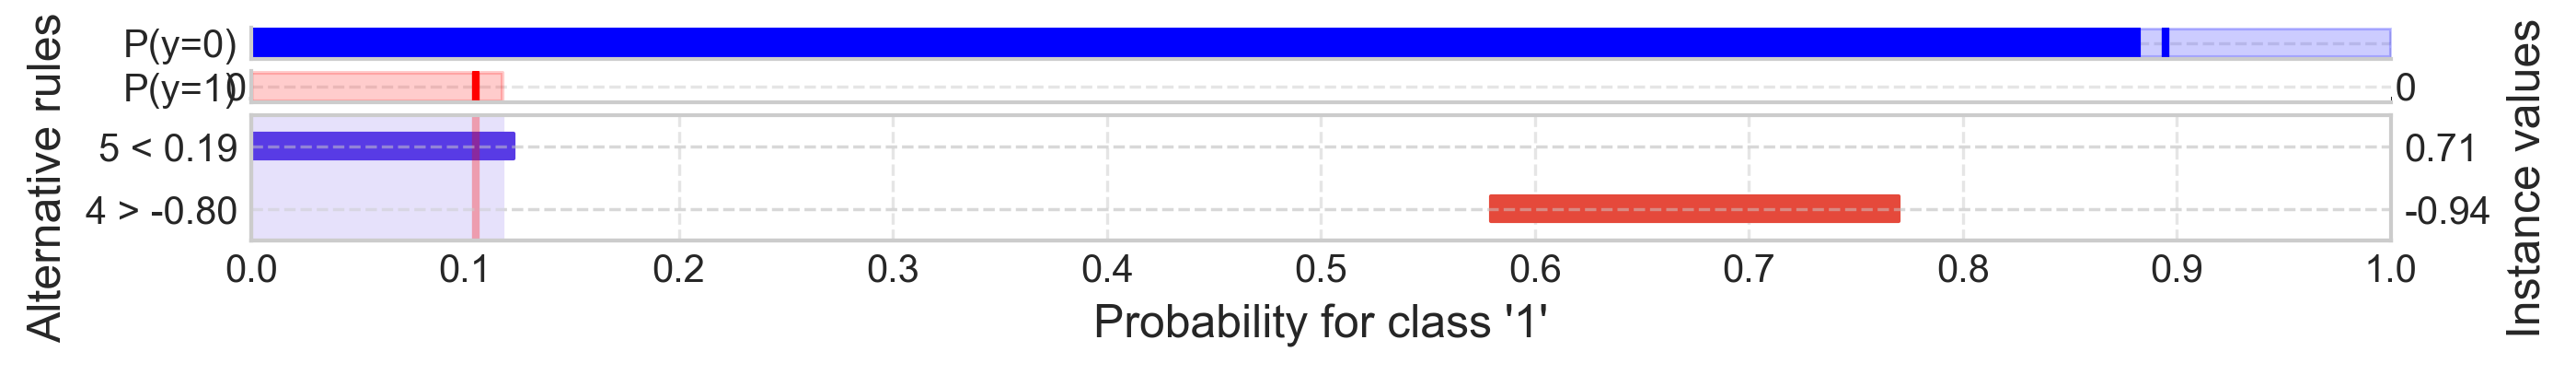

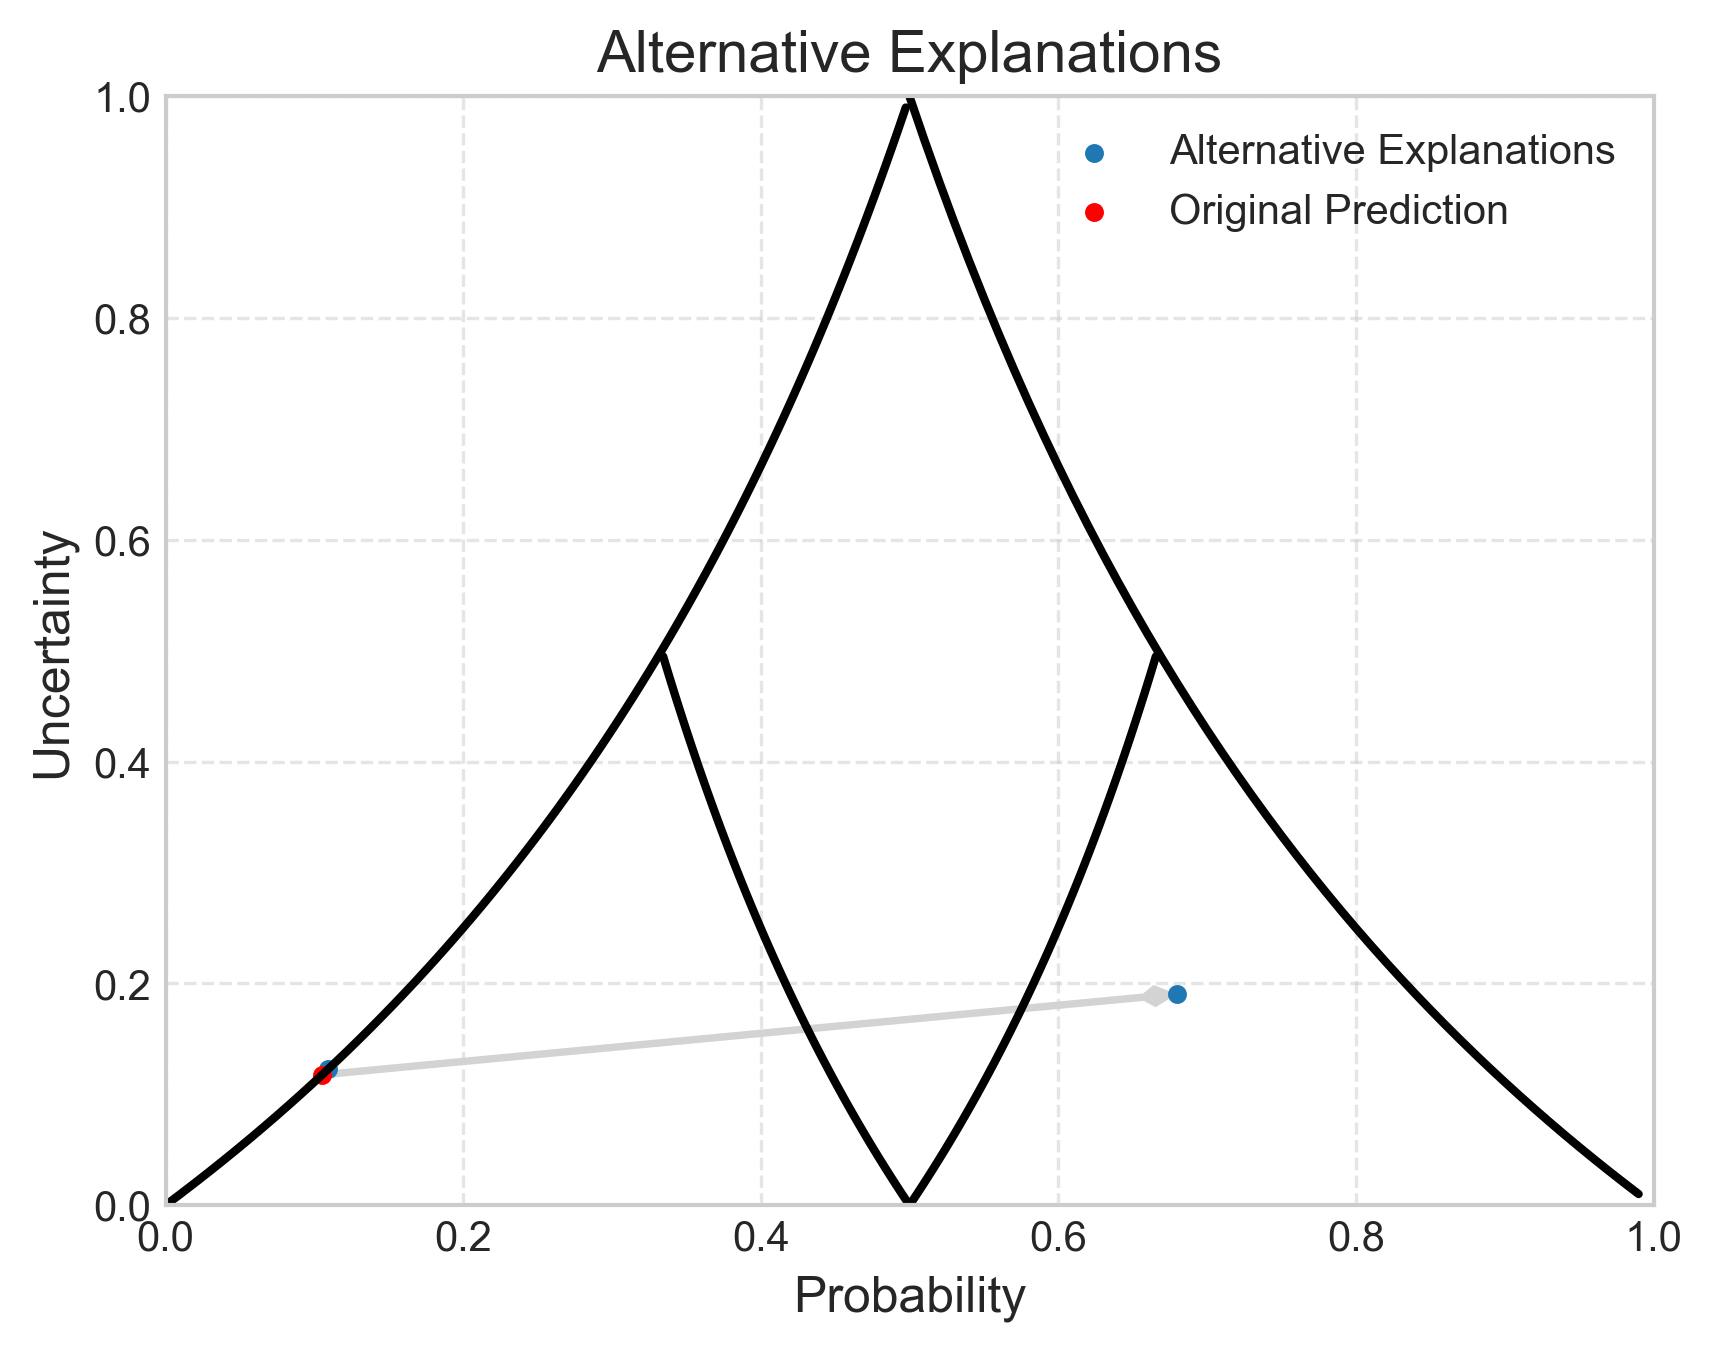

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\loftuw\AppData\Local\anacon

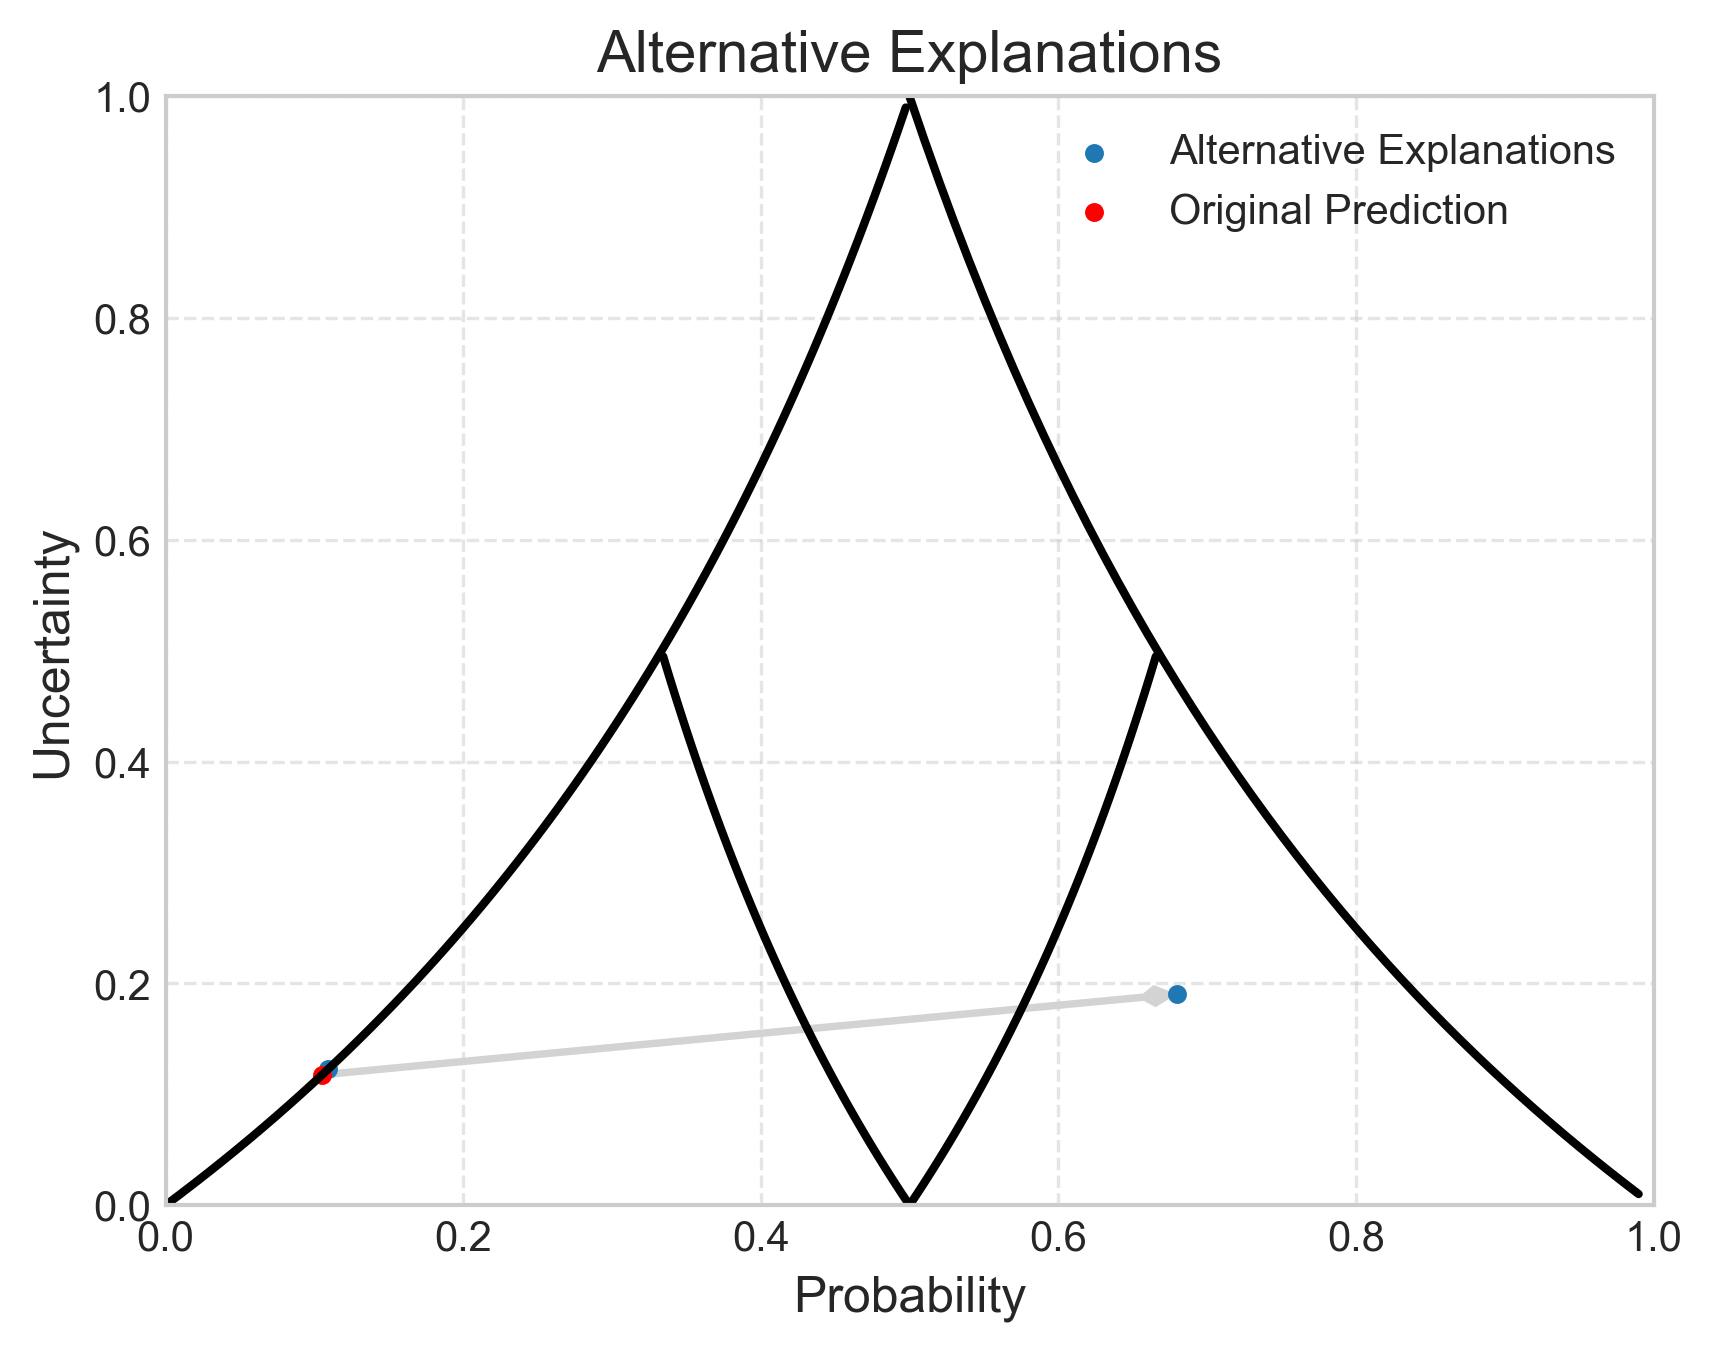

In [ ]:
alternatives = ce.explore_alternatives(x=test_features[:3])
alternatives[0].plot(filter_top=3, rnk_metric="feature_weight")
alternatives[0].plot(style="triangular")
alternatives[0].add_conjunctions()
alternatives[0].plot(style="triangular")
# alternatives[0].plot(filter_top=3) # rnk_metric="ensured", rnk_weight=0.5
# alternatives[0].plot(filter_top=3, rnk_metric="ensured", rnk_weight=-0.5)
# alternatives[0].plot(filter_top=3, rnk_metric="uncertainty")

## CatBoost (CatBoostClassifier)

CatBoost proba_uncal shape: (40, 2)
CatBoost first 3 calibrated probs: [0.15384615 0.17910448 0.85714286]
CatBoost first 3 intervals: [(0.08333333333333333, 0.16666666666666666), (0.08333333333333333, 0.2), (0.8333333333333334, 1.0)]
CatBoost first 10 calibrated predictions: ['0' '0' '1' '0' '1' '0' '1' '0' '1' '1']


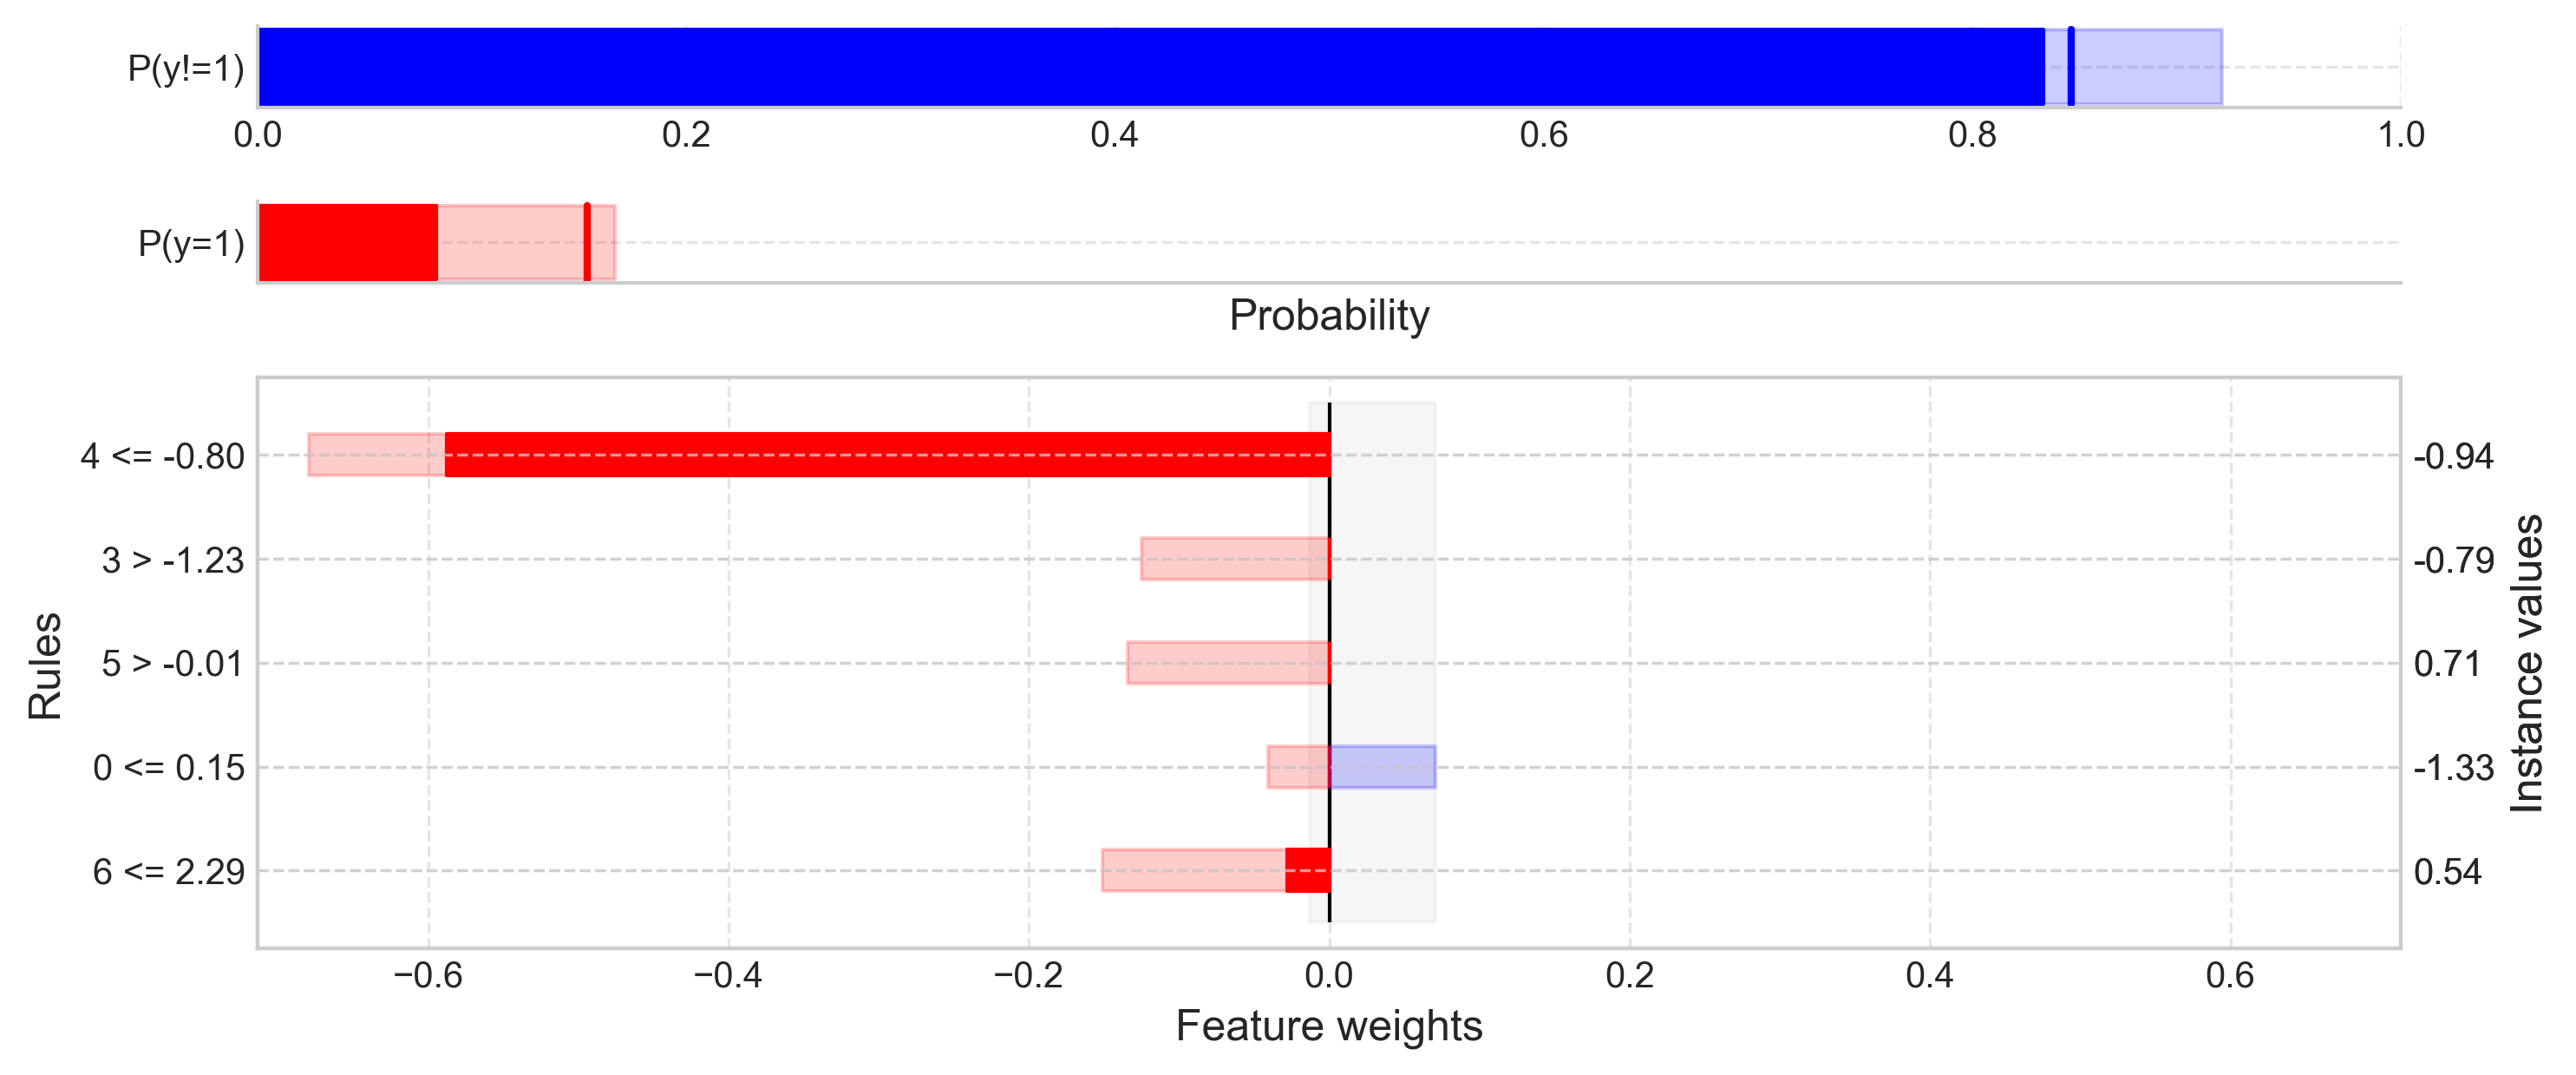

In [ ]:
try:
    import catboost as cb
except Exception as e:
    print("catboost not available, skipping CatBoost demo:", e)
else:
    (
        train_features,
        train_labels,
        calibration_features,
        calibration_labels,
        test_features,
        test_labels,
    ) = make_tiny_binary()
    clf = cb.CatBoostClassifier(
        iterations=60,
        depth=4,
        learning_rate=0.2,
        loss_function="Logloss",
        verbose=False,
        random_seed=42,
    )
    clf.fit(train_features, train_labels)

    ce = CalibratedExplainer(clf, calibration_features, calibration_labels, mode="classification")
    proba_uncal = ce.predict_proba(test_features, calibrated=False)
    proba_cal, (low, high) = ce.predict_proba(test_features, uq_interval=True)
    print("CatBoost proba_uncal shape:", proba_uncal.shape)
    print("CatBoost first 3 calibrated probs:", proba_cal[:3, 1])
    print("CatBoost first 3 intervals:", list(zip(low[:3], high[:3])))

    y_hat, (y_low, y_high) = ce.predict(test_features, uq_interval=True)
    print("CatBoost first 10 calibrated predictions:", y_hat[:10])

    factuals = ce.explain_factual(x=test_features[:3])
    factuals[0].plot(uncertainty=True)

C:\Users\loftuw\Documents\Github\kristinebergs-calibrated_explanations\src\calibrated_explanations\viz\matplotlib_adapter.py:1199: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout(rect=(0, 0, 1, 0.94))


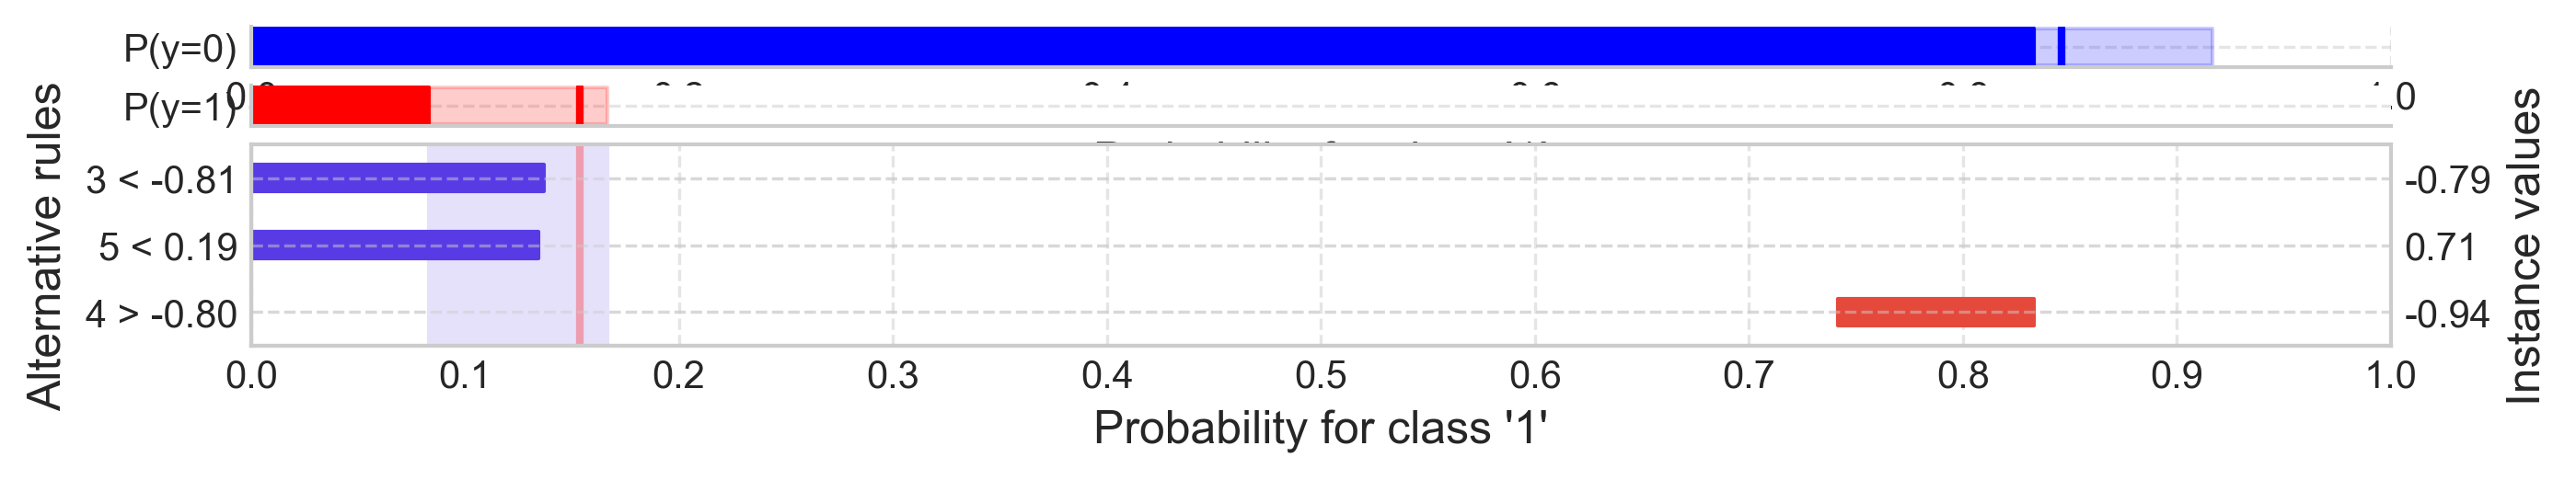

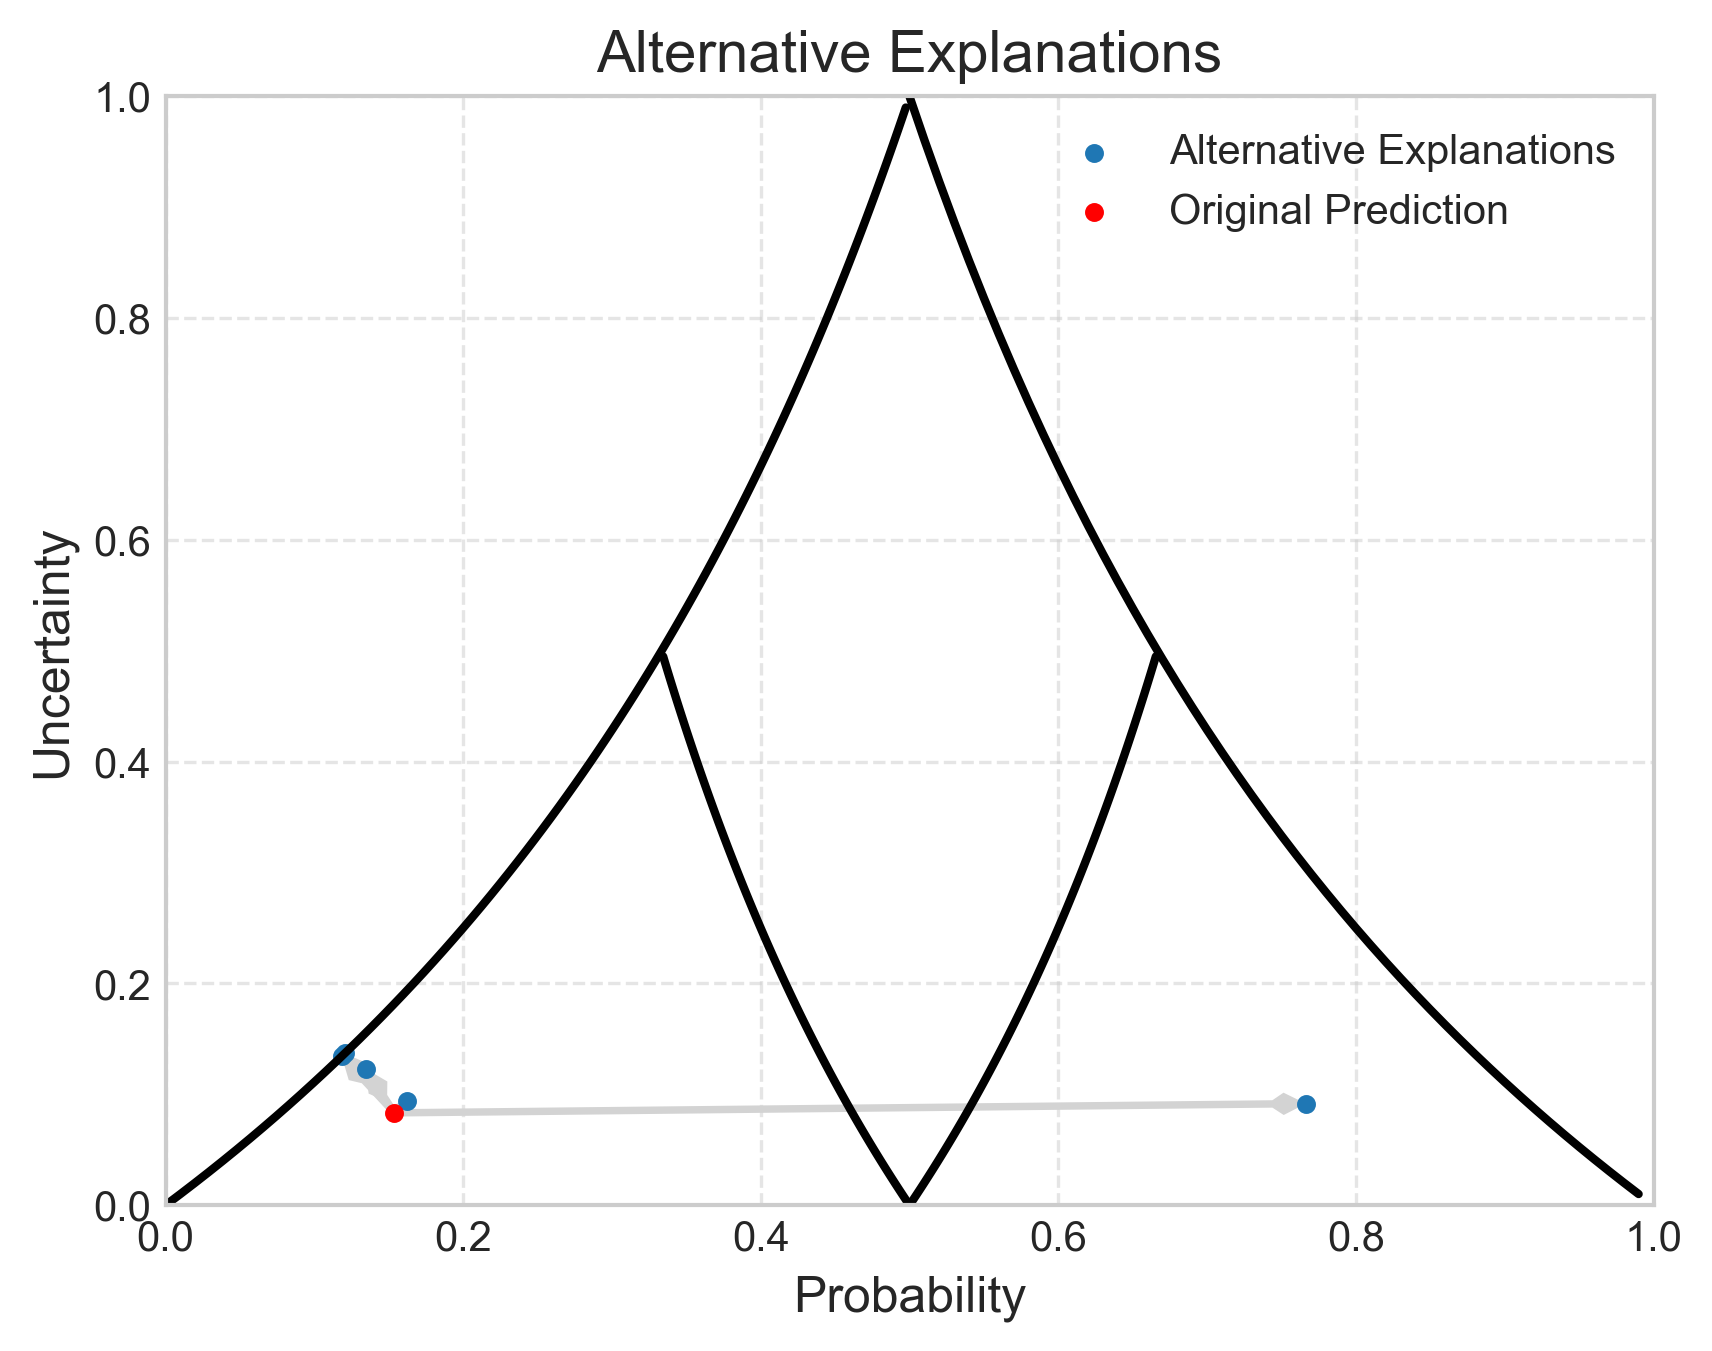

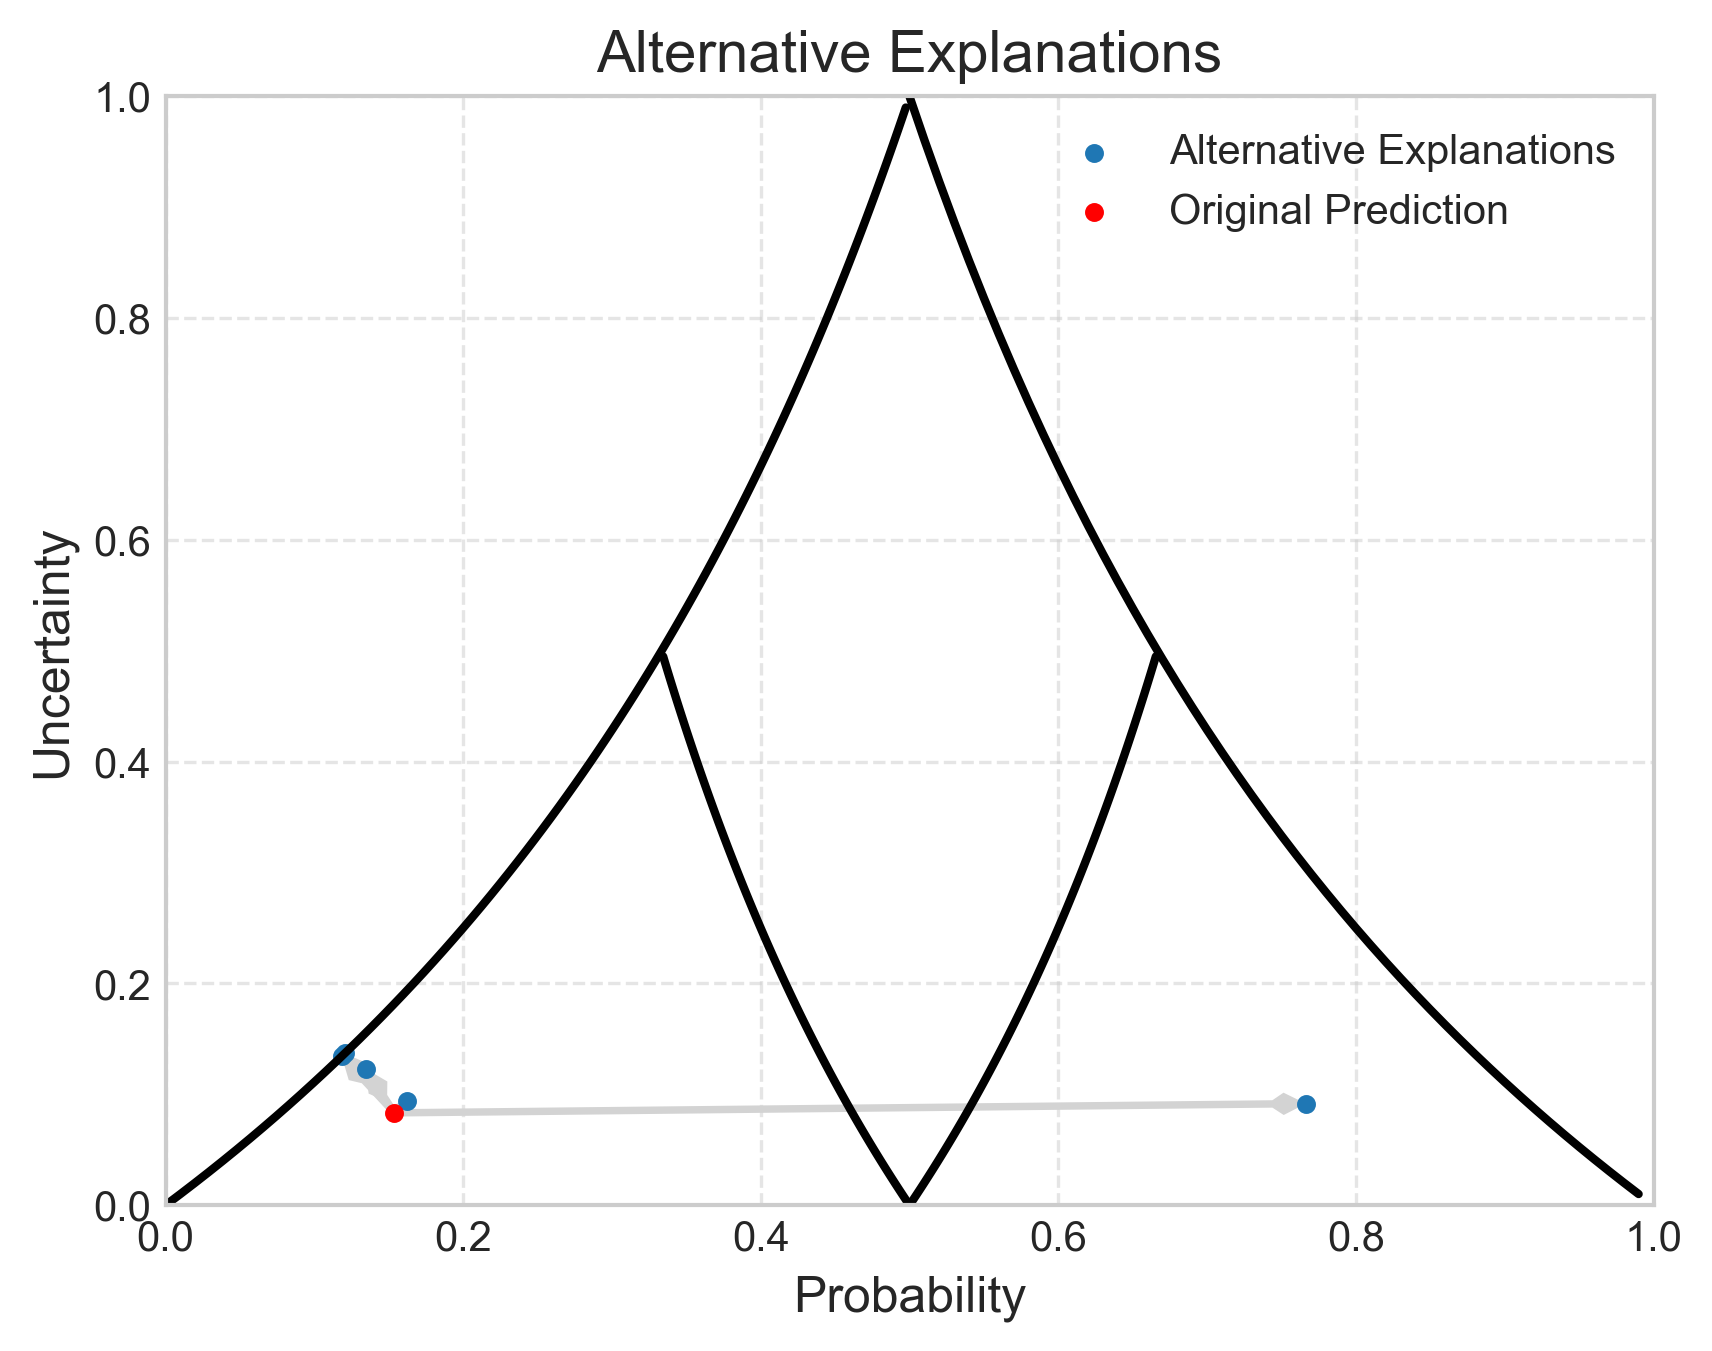

In [ ]:
alternatives = ce.explore_alternatives(x=test_features[:3])
alternatives[0].plot(filter_top=3, rnk_metric="feature_weight")
alternatives[0].plot(style="triangular")
alternatives[0].add_conjunctions()
alternatives[0].plot(style="triangular")
# alternatives[0].plot(filter_top=3) # rnk_metric="ensured", rnk_weight=0.5
# alternatives[0].plot(filter_top=3, rnk_metric="ensured", rnk_weight=-0.5)
# alternatives[0].plot(filter_top=3, rnk_metric="uncertainty")